In [ ]:
!pip install latex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7606 sha256=0c478942813ca52e391d87befb9b98bb90713be5715bd419ac8ed1c04b4d810a
  Stored in directory: /root/.cache/pip/wheels/16/c1/33/30e79ef1232ec43bb51b17ad60c5bfa6849fa0c9bc939ca089
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7246 sha256=b1289fe1c88bad32a603bd0ec5a044e8cc3e403f111480b552489fd26e4116f7
  Stored in directory: /root/.cache/pip/wheels/5c/78/30/ac68ac8de8481b3b4334617a48ef1758323f30709b2f923362
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2782 sha256=88f537383bc33d57f939b2bf8a63515952a4fcdda723b0de3ac30df2098cc911
  Stored in directory: /root/.cache/pip/wheels/27/f1/8b/8e9215b5809387fcf93d0eb9c1a95a7cb30b369b3c1d986f1c
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.whl size=2213 sha256=2b98a33e1d0f69b4dd5dfd3a15046942e345126f6ead9

In [ ]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import deque 
from copy import deepcopy
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from collections import deque
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

## Реализуем крестики-нолики

In [1]:
### Часть 1

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [ ]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.space = np.array([(i, j) for i in range(self.n_rows) for j in range(self.n_cols)])
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        self.reset()
    
    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def tensor_from_hash(self):
        board_hash = self.getHash()
        board_hash = np.array([int(digit) for digit in board_hash])
        res = np.zeros((3, self.n_rows * self.n_cols))
        res[board_hash, np.arange(len(board_hash))] = 1
        res = res.reshape(3, self.n_rows, self.n_cols)
        return torch.unsqueeze(torch.Tensor(res).to(torch.float32), 0)


    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [ ]:
class Strategy():
    def __init__(self, epsilon=0.1):
        self.Q = {}
        self.epsilon = epsilon
    
    
    def getAction(self, s, num_actions, pi2=None, init_zero=False):
        if s not in self.Q:
            if init_zero:
                self.Q[s] = np.zeros(num_actions)
            else:
                self.Q[s] = np.random.random(size=num_actions) * 2 - 1
        if pi2 is not None:
            if s not in pi2.Q:
                if init_zero:
                    pi2.Q[s] = np.zeros(num_actions)
                else:
                    pi2.Q[s] = np.random.random(size=num_actions) * 2 - 1
            return np.argmax(self.Q[s] + pi2.Q[s]) if np.random.rand() > self.epsilon else np.random.randint(num_actions)
        return np.argmax(self.Q[s]) if np.random.rand() > self.epsilon else np.random.randint(num_actions)


    def getActionGreedy(self, s, num_actions, pi2=None, init_zero=False):
        if s not in self.Q:
            return np.random.randint(num_actions)
        if pi2 is not None:
            if s not in pi2.Q:
                if init_zero:
                    pi2.Q[s] = np.zeros(num_actions)
                else:
                    pi2.Q[s] = np.random.random(size=num_actions) * 2 - 1
            return np.argmax(self.Q[s] + pi2.Q[s])
        return np.argmax(self.Q[s])
    
    def updateQ(self, s, a, goal, reward, num_actions, gamma = 0.9, alpha=0.1):
        if s not in self.Q:
            self.Q[s] = np.zeros(num_actions)
        expected = reward + gamma * goal
        self.Q[s][a] += alpha * (expected - self.Q[s][a])

In [ ]:
def plot_board(env, pi, showtext=True, verbose=True):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=20, horizontalalignment='center', verticalalignment='center', color="w" )
            else:
                ax.text( a[1] , a[0] , "???", fontsize=20, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()


def get_and_print_move(env, pi, s, actions, random=False, verbose=True):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi)
    if random:
        return np.random.randint(len(actions))
    else:
        if verbose:
            if pi is not None and s in pi.Q:
                for i,a in enumerate(actions):
                    print(i, a, pi.Q[s][i])
            else:
                print("Стратегия не знает, что делать...")
        return pi.getActionGreedy(s, len(actions))


def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        print(s, "\n")
        print(actions, "\n")
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose)
        observation, reward, done, info = env.step(actions[a])
        if verbose:
            env.printBoard()
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False)


def check_reward(reward, student, swap_num=10):
  if reward == -10:
      if student == -1:
        reward = swap_num
      else:
        reward = -swap_num
  return reward

In [ ]:
def play(env, player_1, player_2, student, iters):
  results = []
  main_player = player_1 if student == 1 else player_2
  
  for i in range(iters):
    env.reset()
    done = False
    queue = []
    step = 0

    while not done:
      state, actions, _ = env.getState()

      if step % 2 == 0 and step != 0:
        reward = check_reward(reward, student)
        reward *= student
        prev_state, prev_pos, prev_action_length = queue[-1]
        curr_Q = np.max(main_player.Q[state]) if main_player.Q.get(state) is not None else 0
        main_player.updateQ(prev_state, prev_pos, curr_Q, reward, prev_action_length)

      if env.curTurn == 1:
        pos = player_1.getAction(state, len(actions))
      else:
        pos = player_2.getAction(state, len(actions))
      
      if env.curTurn == student:
        queue.append((state, pos, len(actions)))
      
      _, reward, done, _ = env.step(actions[pos])
      step += 1
      
      if done:
        reward = check_reward(reward, student)
        reward *= student
        prev_state, prev_pos, prev_action_length = queue[-1]
        state, actions, _ = env.getState()
        curr_Q = np.max(main_player.Q[state]) if main_player.Q.get(state) is not None else 0
        main_player.updateQ(prev_state, prev_pos, curr_Q, reward, prev_action_length)
        results.append(reward)
  return results

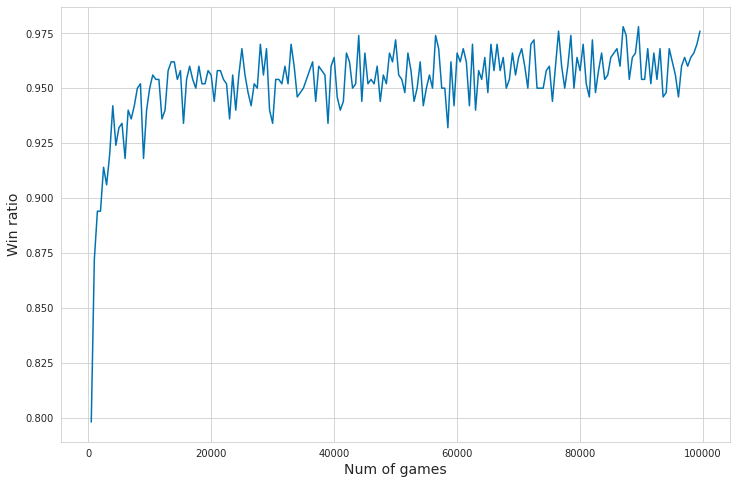

In [ ]:
### Играем за крестики 3x3
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
player_1 = Strategy()
player_2 = Strategy()

res = play(env, player_1, player_2, 1, 100000)

width = 500
ind = [i * width for i in range(1, len(res) // width)]
avgs = []
for i in ind:
    sub = res[i-width:i]
    avg = sum(1 for x in sub if x == 1) / width
    avgs.append(avg)

plt.figure(figsize=(12,8))
plt.plot(ind, avgs)
plt.xlabel("Num of games", fontsize=14)
plt.ylabel("Win ratio", fontsize=14)
plt.show()

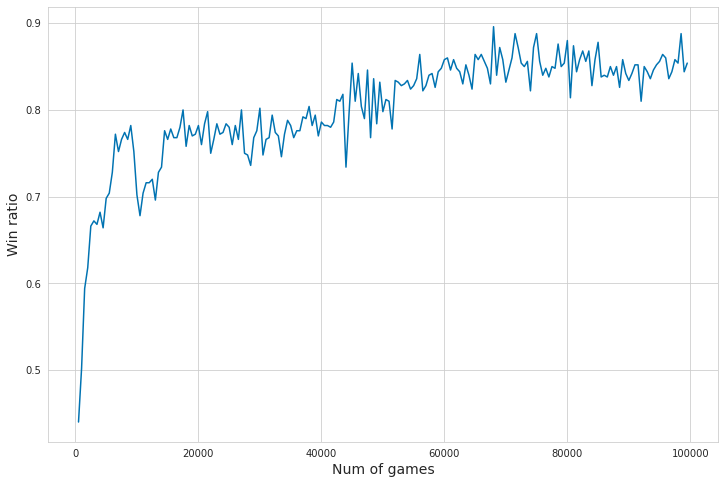

In [ ]:
### Играем за нолики 3x3
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
player_1 = Strategy()
player_2 = Strategy()

res = play(env, player_1, player_2, -1, 100000)

width = 500
ind = [i * width for i in range(1, len(res) // width)]
avgs = []
for i in ind:
    sub = res[i-width:i]
    avg = sum(1 for x in sub if x == 1) / width
    avgs.append(avg)

plt.figure(figsize=(12,8))
plt.plot(ind, avgs)
plt.xlabel("Num of games", fontsize=14)
plt.ylabel("Win ratio", fontsize=14)
plt.show()

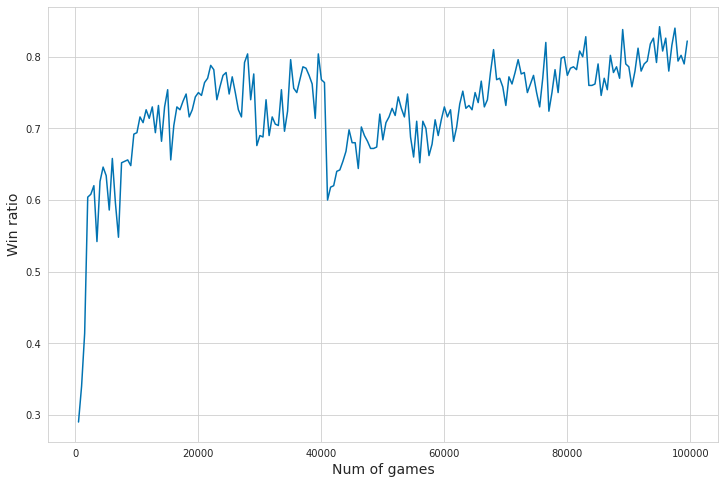

In [ ]:
### Играем за крестики 4x4
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
player_1 = Strategy()
player_2 = Strategy()

res = play(env, player_1, player_2, 1, 100000)

width = 500
ind = [i * width for i in range(1, len(res) // width)]
avgs = []
for i in ind:
    sub = res[i-width:i]
    avg = sum(1 for x in sub if x == 1) / width
    avgs.append(avg)

plt.figure(figsize=(12,8))
plt.plot(ind, avgs)
plt.xlabel("Num of games", fontsize=14)
plt.ylabel("Win ratio", fontsize=14)
plt.show()

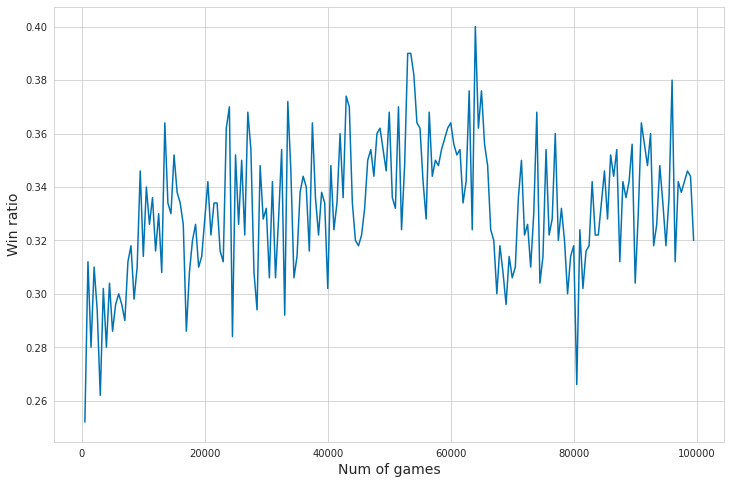

In [ ]:
### Играем за нолики 4x4
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
player_1 = Strategy()
player_2 = Strategy()

res = play(env, player_1, player_2, -1, 100000)

width = 500
ind = [i * width for i in range(1, len(res) // width)]
avgs = []
for i in ind:
    sub = res[i-width:i]
    avg = sum(1 for x in sub if x == 1) / width
    avgs.append(avg)

plt.figure(figsize=(12,8))
plt.plot(ind, avgs)
plt.xlabel("Num of games", fontsize=14)
plt.ylabel("Win ratio", fontsize=14 )
plt.show()

In [2]:
### Часть 2

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.optim import Adam
from collections import deque

DEVICE = "cpu" if not torch.cuda.is_available() else "cuda"

In [ ]:
class ReplayBuffer():
    def __init__(self, capacity=200000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def add(self, sample):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = sample
        self.position = (self.position + 1) % self.capacity
       
    def get_batch(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)


class QNetwork(nn.Module):
    def __init__(self, action_dim, channels=120):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, channels, 3)
        self.ln1 = nn.Linear(channels, 512)
        self.ln2 = nn.Linear(512, action_dim)
    
    def forward(self, x):
        """
        Input: tensor batch_size x C x W x H
        Output: tensor batch_size x 9
        """
        x = F.relu(self.conv(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x

In [ ]:
class DQN:
    def __init__(self, action_dim, channels=240, lr=0.0001):
        self.steps = 0
        self.qnetwork_local = QNetwork(action_dim, channels).to(DEVICE)
        #self.qnetwork_target  = QNetwork(action_dim, channels).to(DEVICE)
        self.optimizer = Adam(self.qnetwork_local.parameters(), lr)
        self.buffer = ReplayBuffer()

    def getAction(self, state, empty_spaces, eps=0.1):
      if random.random() < eps:
        return np.random.randint(0, len(empty_spaces))
      
      self.qnetwork_local.eval()
      with torch.no_grad():
        action = self.qnetwork_local(state)
      self.qnetwork_local.train()
      return np.argmax(action.cpu().data.numpy())

    def consume_transition(self, transition):
      self.buffer.add(transition)

    def update(self):
      transitions = self.buffer.get_batch(BATCH_SIZE)
      states, actions, next_states, rewards = zip(*transitions)
      states = Variable(torch.cat(states)).to(DEVICE)
      #print(f"States = {states.shape}")
      actions = torch.tensor(np.array(actions, dtype=np.int)).unsqueeze(1).to(DEVICE)
      #print(f"actions = {actions}")
      rewards = torch.tensor(np.array(rewards, dtype=np.float32)).to(DEVICE)
      #print(f"rewards = {rewards}")
      next_states = Variable(torch.cat(next_states)).to(DEVICE)
      #print(f"next_states = {next_states.shape}")
      q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0]
      #print("Q_target", q_targets_next.shape)
      q_targets = rewards + GAMMA * q_targets_next
      #print(q_targets.shape)
      q_expected = self.qnetwork_local(states).gather(1, actions).squeeze()
      #print(f"Expected - {q_expected.shape}")
      loss = F.smooth_l1_loss(q_expected, q_targets)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step() 

    def update_target_network(self):
        # Update weights of a target Q-network here. You may use copy.deepcopy to do this or 
        # assign a values of network parameters via PyTorch methods.
        #self.qnetwork_target = copy.deepcopy(self.qnetwork_local)
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(local_param.data)        
        return

In [ ]:
def play(env, player, student, episodes, store_epochs, train_epochs):
  results = []
  buffer = ReplayBuffer()

  for episode in range(episodes):
    print(episode)
    for transition_step in range(store_epochs):
      env.reset()
      state = env.tensor_from_hash()
      actions = env.getEmptySpaces()
      done = False
      if student == -1:
        act_idx = player.getAction(state, empty_spaces=actions, eps=1)
        env.step(actions[act_idx])
        state = env.tensor_from_hash()
        actions = env.getEmptySpaces()
      
      while not done:
        player_act_idx = player.getAction(state.to(DEVICE), empty_spaces=actions)
        player_action = env.space[player_act_idx]
        (_, _, _), reward, done, _ = env.step(player_action)
        next_state = env.tensor_from_hash()
        next_actions = env.getEmptySpaces()
        reward = check_reward(reward, student)
        if done:
          transition = (state, player_act_idx, next_state, reward * student)
          player.consume_transition(transition)
          results.append(reward * student)
          break
        
        random_player = player.getAction(next_state.to(DEVICE), empty_spaces=next_actions, eps=1)
        random_player_action = next_actions[random_player]
        #print(next_actions)
        (_, _, _), reward, done, _ = env.step(random_player_action)
        next_state = env.tensor_from_hash()
        reward = check_reward(reward, student)
        transition = (state, player_act_idx, next_state, reward * student)
        player.consume_transition(transition)
        state = next_state
        actions = env.getEmptySpaces()
        #print(actions)
    
    for epoch in range(train_epochs):
      #print('epoch')
      player.update()
      #print('epoch')
      # if epoch % 100 == 0:
      #   player.update_target_network()


  return results

In [ ]:
%%time
N_ROWS, N_COLS = 3, 3
BATCH_SIZE = 256
GAMMA = 0.9
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=3)
player = DQN(N_ROWS * N_COLS)
games = play(env, player, 1, 50, 5000, 1000)

0


<ipython-input-131-80e18e3301e3>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions = torch.tensor(np.array(actions, dtype=np.int)).unsqueeze(1).to(DEVICE)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
CPU times: user 10min 45s, sys: 5.15 s, total: 10min 50s
Wall time: 10min 54s


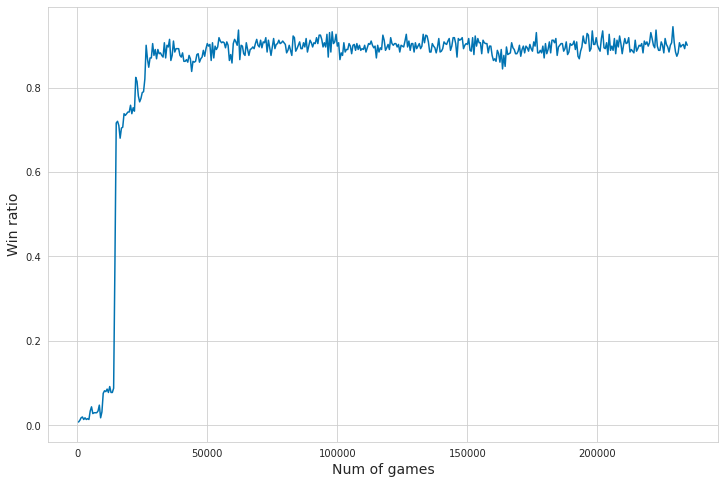

In [ ]:
width = 500
ind = [i * width for i in range(1, len(games) // width)]
avgs = []
for i in ind:
    sub = games[i - width:i]
    avg = sum(1 for x in sub if x == 1) / width
    avgs.append(avg)

plt.figure(figsize=(12,8))
plt.plot(ind, avgs)
plt.xlabel("Num of games", fontsize=14)
plt.ylabel("Win ratio", fontsize=14 )
plt.show()

In [ ]:
%%time
N_ROWS, N_COLS = 3, 3
BATCH_SIZE = 256
GAMMA = 0.9
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=3)
player = DQN(N_ROWS * N_COLS)
games = play(env, player, -1, 50, 5000, 1000)

0


<ipython-input-17-80e18e3301e3>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions = torch.tensor(np.array(actions, dtype=np.int)).unsqueeze(1).to(DEVICE)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
CPU times: user 16min 2s, sys: 9.28 s, total: 16min 11s
Wall time: 16min 11s


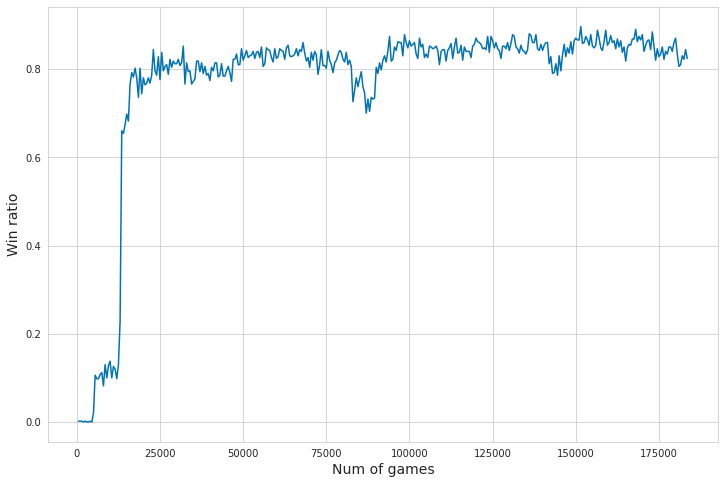

In [ ]:
width = 500
ind = [i * width for i in range(1, len(games) // width)]
avgs = []
for i in ind:
    sub = games[i-width:i]
    avg = sum(1 for x in sub if x == 1) / width
    avgs.append(avg)

plt.figure(figsize=(12,8))
plt.plot(ind, avgs)
plt.xlabel("Num of games", fontsize=14)
plt.ylabel("Win ratio", fontsize=14 )
plt.show()

In [3]:
### Часть 3

In [ ]:
def random_policy(env, state, noughts=False):
    action_space = env.getEmptySpaces()
    return tuple(action_space[np.random.randint(0, len(action_space))])


def make_rollout_policy(num_samples, base_policy):
    def policy(env, state, noughts):
        return rollout_step(env, base_policy, noughts=noughts, num_samples=num_samples)
    return policy


def evaluate_policy_against_random(env, policy, num_samples):
    estimations = []
    for noughts in [False, True]:
        outcomes = []
        if noughts:
            print('Evaluating noughts...')
        else:
            print('Evaluating crosses...')
        for _ in tqdm(range(num_samples)):
            state_crosses = env.reset()
            noughts_finished = True
            done = False
            while not done:
                action_crosses = random_policy(env, state_crosses, noughts=False) if noughts else policy(env, state_crosses, noughts=False)
                (state_noughts, _, _), reward, done, _ = env.step(action_crosses)
                if not done:
                    action_noughts = policy(env, state_noughts, noughts=True) if noughts else random_policy(env, state_noughts, noughts=True)
                    (state_crosses, _, _), reward, done, _ = env.step(action_noughts)
                else:
                    noughts_finished = False
            if noughts and abs(round(reward)) == 1:
                reward *= -1
            if noughts != noughts_finished and round(reward) == -10:
                # enemy chose a non-empty cell
                reward = 1
            outcomes.append(reward)
        estimations.append(np.mean(outcomes))
    return estimations


def rollout_step(env, policy, num_samples=1000, noughts=False):
    action_space = env.getEmptySpaces()
    estimations = []
    for action in action_space:
        outcomes = []
        for _ in range(num_samples):
            env_copy = deepcopy(env)
            current_noughts = noughts
            (state, _, _), reward, done, _ = env_copy.step(action)
            while not done:
                current_noughts ^= True
                (state, _, _), reward, done, _ = env_copy.step(policy(env_copy, state, current_noughts))
            if noughts and round(abs(reward)) == 1:
                reward *= -1
            if round(reward) == -10 and (current_noughts != noughts):
                # enemy chose a non-empty cell
                reward = 1
            outcomes.append(reward)
        estimations.append(np.mean(outcomes))
    return tuple(action_space[np.argmax(estimations)])

In [ ]:
def rollout_step(env, policy, student, episodes=100):
    action_space = env.getEmptySpaces()
    action_stats = []
    for action in action_space:
        stats = []
        for _ in range(episodes):
            env_copy = deepcopy(env)
            (state, _, _), reward, done, _ = env_copy.step(action)
            while not done:
                (state, _, _), reward, done, _ = env_copy.step(policy(env_copy))
            reward = check_reward(reward, student, 1)
            stats.append(reward * student)
        action_stats.append(np.mean(stats))
    return action_space[np.argmax(action_stats)]

In [ ]:
def random_policy(env):
  empty_spaces = env.getEmptySpaces()
  return empty_spaces[np.random.randint(0, len(empty_spaces))]

In [ ]:
def mcts(env, policy, student, episodes):
  stats = []
  for eposide in tqdm(range(episodes)):
    env.reset()
    cross_state = env.getHash()
    done = False
    while not done:
      cross_action = rollout_step(env, policy, student) if student == 1 else random_policy(env)
      (zero_state, _, _), reward, done, _ = env.step(cross_action)
      if not done:
        zero_action = rollout_step(env, policy, student) if student == -1 else random_policy(env)
        (cross_state, _, _), reward, done, _ = env.step(zero_action)
      reward = check_reward(reward, student, 1)
    stats.append(reward * student)
  return np.mean(stats)

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
mcts(env, random_policy, 1, 1000)

100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s]


0.989

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
mcts(env, random_policy, -1, 1000)

100%|██████████| 1000/1000 [10:45<00:00,  1.55it/s]


0.853

In [ ]:
### Обученный игрок за крестики на 3x3 сетке из первой части Q-learning

In [ ]:
def q_policy(env):
  state = env.getHash()
  space = env.getEmptySpaces()
  action = player_1.getActionGreedy(state, len(space))
  return space[action]

In [ ]:
# Крестики

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
mcts(env, q_policy, 1, 1000)

100%|██████████| 1000/1000 [14:37<00:00,  1.14it/s]


0.978

In [ ]:
# Нолики

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
mcts(env, q_policy, -1, 1000)

100%|██████████| 1000/1000 [11:15<00:00,  1.48it/s]


0.689